In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [1]:
import kagglehub
import os                                                ##  Modul os je součástí standardní knihovny Pythonu a umožňuje pracovat se soubory a adresáři v operačním systému. 
                                                         ##  Často se používá ke čtení/zápisu souborů, získání cest k souborům a manipulaci s adresáři. 

from PIL import Image                                    ## PIL (Python Imaging Library, dnes známá jako Pillow) je knihovna pro manipulaci s obrázky. 
                                                         ## Image umožňuje otevírat, upravovat a ukládat obrázky ve formátech jako PNG, JPEG, BMP atd. 

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split     ## Rozdělení datasetu na trénovací a testovací část
from keras.utils import to_categorical                   ##  Konverze štítků do One-Hot Encoding, Místo číselného označení jako 0, 1, 2, 
                                                         ##  což by mohlo způsobit chyby v učení (síť by mohla mylně považovat 2 za „větší“ než 1), použijeme One-Hot Encoding:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionV3
from keras.applications import MobileNetV3Large     ## je předtrénovaný model hlubokého učení určený pro rozpoznávání obrazu.
                                                    ## Model je předtrénován na obrovském datasetu ImageNet a lze jej dále upravit (tzv. transfer learning).
from keras.layers import GlobalAveragePooling2D     ## redukuje dimenzionalitu výstupních dat.
from keras.models import Model                      ## Model umožňuje sestavit vlastní architekturu neuronové sítě v Kerasu.
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
def plot_history(history):
  """
  Funkce na vykreslení dat z objectu history -> vrací ho metoda fit keras modelu
  """
  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

In [3]:
# The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

# The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories 

#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). 

#The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

## Načtení a preprocessing dat

In [8]:
path = r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE"

In [9]:
# data se stáhly sem -> ručně jsem hledal, od jaké úrovně složek už jsou data
fotky_emoce = os.listdir(f"{path}/train_OK")
fotky_emoce

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [10]:
# potřebuji načíst fotky, k fotkám labely a uložit si, jaký label patří k jaké emoci
X = []     ## Sem budeme ukládat načtené obrázky jako numpy array
y = []     ## Sem budeme ukládat číselné labely (indexy emocí)
encoding = {}    ##  Mapa, která přiřazuje čísla (indexy) konkrétním emocím
# pro každou složku s figurkami
for index, emoce in enumerate(fotky_emoce):        # fotky_emoce -  seznam složek, kde každá složka obsahuje fotky jedné emoce (např. "happy", "sad", "angry"), 
                                                   # enumerate(fotky_emoce) nám umožní přiřadit každé emoci unikátní číslo (index).
  # uložíme si přiřazení číel k labelům y
  encoding[index] = emoce
  # složka s fotkami kontrétních emoci
  folder_path = os.path.join(f"{path}/train_OK", emoce)

  # sem načteme fotky konkrétních emoci
  image_list = []      #  Vytvoříme prázdný list, kam budeme ukládat obrázky pro aktuální emoci.
  # pro každý soubor ze složky
  for filename in os.listdir(folder_path):
    # pokud se jedná o .jpg
    if filename.endswith(".jpg"):      # Projdeme všechny soubory ve složce aktuální emoce.
        # cesta ke kokrétnímu souboru
        img_path = os.path.join(folder_path, filename)
        # načti obrázek ze souboru
        img = Image.open(img_path)
        # Změň rozlišení na 224x224 -> všechny budou mít stejný rozměr
        img_resized = img.resize((48, 48))         #  # Změníme velikost na 48x48 pixelů, Změníme velikost obrázku, aby všechny měly stejný rozměr, To je důležité pro konzistentní vstupy do neuronové sítě.
        # převeď na numpy array
        img_array = np.array(img_resized)
        # přidat do listu k ostatním
        image_list.append(img_array)
  # do X přidej obrázky z další složky (respektive emoce)
  X += image_list    #   Přidáme všechny obrázky z této složky do seznamu X.
  # vytvoříme list s labely (rovnou jako čísla, ať nemusíme pozdějí dělat encoding)
  # přiřazení čísel k labelům máme v proměnné 'encoding'
  y += [index] * len(image_list)

In [11]:
# převést list s numpy arrayi pro každou emoci na numpy array (tenzor)
X = np.stack(X)
# převést list y na numpy array
y = np.array(y)

In [12]:
# transfer learning viz. níže -> zvolili jsme Mobilnetv3 jako základ
# ten vyžaduje hodnoty pixelů v rozmezí od 0-255 -> neškálovat!
X_not_scaled = X.copy()

In [13]:
# škálujeme pro náš vlastní model,  Normalizování obrázků
X = X / 255

In [14]:
# rozdělení, trénink test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
# one hot encoding y -> musí sedět rozměr s výstupem softmax vrstvy
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
early = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.3%
    min_delta=0.003,
    # za posledních 10 epoch
    patience=10,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    ## start_from_epoch = 50
)

save = ModelCheckpoint(
    # kam uložit model
    filepath="best_model.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)

## Vlastní neuronka

In [14]:
# vytvoříme vlastní model - inspirace VGG16 architektura
model = Sequential()
# vstup musí sedět na X
model.add(Input(shape=(48, 48, 1)))
## model.add(Input(shape=X_train.shape[1:]))
# blok konvoluce s poolingem
model.add(Conv2D(32, (3, 3),input_shape=(48, 48, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D())
# převést na vektor
model.add(Flatten())
# regularizace proti overfittingu
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
# výstupní vrstva -> multiclass single label -> softmax
model.add(Dense(len(fotky_emoce), activation="softmax"))

# kompilace
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

C:\Users\zitao\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,167 (625.65 KB)

 Trainable params: 160,167 (625.65 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
## Total params:   Celkový počet parametrů ve vašem modelu, které jsou trénovatelné i netrénovatelné dohromady.
## Trainable params:  Počet parametrů, které se mění během trénování – model se učí jejich optimální hodnoty.

In [16]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.3849 - loss: 1.6573 - val_accuracy: 0.5783 - val_loss: 1.2104
Epoch 2/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5860 - loss: 1.1686 - val_accuracy: 0.6207 - val_loss: 1.0679
Epoch 3/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6474 - loss: 1.0172 - val_accuracy: 0.6627 - val_loss: 0.9333
Epoch 4/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6746 - loss: 0.9104 - val_accuracy: 0.6791 - val_loss: 0.8959
Epoch 5/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7047 - loss: 0.8299 - val_accuracy: 0.7136 - val_loss: 0.8118
Epoch 6/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7286 - loss: 0.7610 - val_accuracy: 0.7192 - val_loss: 0.7902
Epoch 7/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7568 - loss: 0.6820 - val_accuracy: 0.7218 - val_loss: 0.7853
Epoch 8/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7729 - loss: 0.6442 

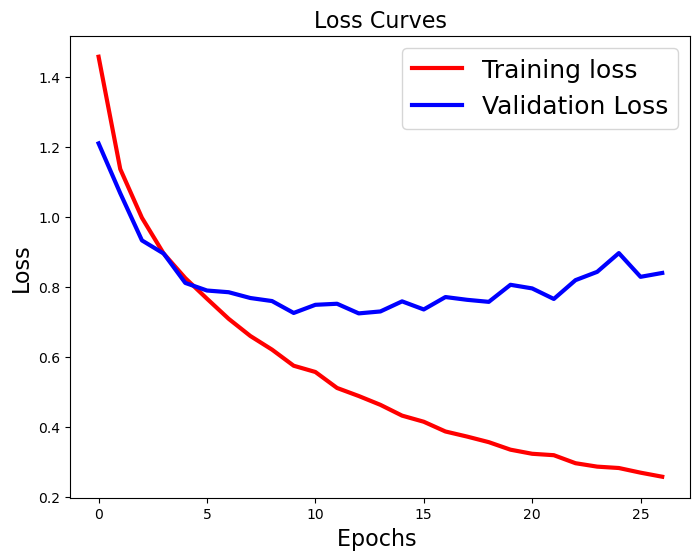

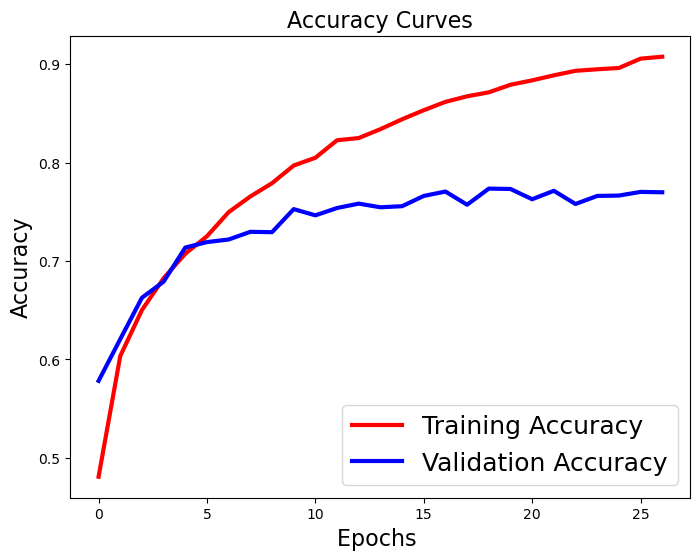

In [17]:
plot_history(history)

In [18]:
model = load_model("best_model.keras")

In [19]:
y_pred = model.predict(X_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [20]:
y_pred = np.argmax(y_pred, axis=1)

In [21]:
y_test = np.argmax(y_test, axis=1)

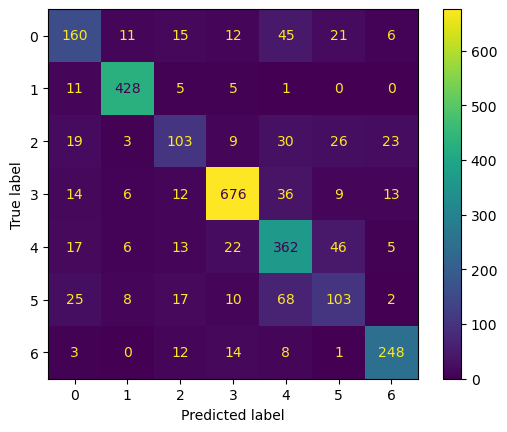

In [22]:
# plt.title("Confusion Matrix  - Vlastní neuronka")  # Název grafu
# plt.xlabel('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')  # Popisek osy X
# plt.ylabel("Skutečné třídy")  # Popisek osy Y

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Transfer learning

## Transfer learning je technika v hlubokém učení, která umožňuje využít znalosti z již natrénovaného modelu pro nový úkol.

In [16]:
# Convert single-channel grayscale to 3-channel format (R=G=B=gray)
rgb_image = np.stack((X_not_scaled,) * 3, axis=-1)

In [17]:
rgb_image.shape

(13441, 48, 48, 3)

In [18]:
# vytvořit trénovací sadu z nenaškálovaných dat
X_train, X_test, y_train, y_test = train_test_split(
    rgb_image, y, test_size=0.2, stratify=y, random_state=42)       ##  20 % dat se použije pro testování, 80 % pro trénování,  42 - zajišťuje, že náhodné rozdělení bude stejné při každém spuštění.
                                                                       ## stratify=y – zajistí, že rozložení tříd (emocí) bude stejné v trénovacím i testovacím datasetu.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
early_learning = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.3%
    min_delta=0.003,
    # za posledních 10 epoch
    patience=10,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    ## start_from_epoch = 50
)

save_learning = ModelCheckpoint(
    # kam uložit model
    filepath="best_model_learning_mobilnet.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)

In [20]:
# Načtení základního modelu MobileNetV3Large bez vrchní plně propojené vrstvy
base_model = MobileNetV3Large(
    input_shape=(48, 48, 3),  # Vstupní tvar pro šedotónové obrázky
    include_top=False,
)

# Zamrznutí základního modelu, aby se jeho váhy během trénování neměnily
base_model.trainable = False

# Vytvoření vlastních vrstev pro specifickou úlohu
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
     ## model.add(Dropout(0.3))
    layers.Dense(len(fotky_emoce), activation='softmax')  # 'num_classes' je počet tříd ve vašem datasetu
])

# Kompilace modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\zitao\anaconda3\Lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 2, 2, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,120,263 (11.90 MB)

 Trainable params: 123,911 (484.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [22]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_learning, save_learning])

Epoch 1/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.3896 - loss: 1.6974 - val_accuracy: 0.5184 - val_loss: 1.3255
Epoch 2/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.4967 - loss: 1.3791 - val_accuracy: 0.5337 - val_loss: 1.3063
Epoch 3/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.5077 - loss: 1.3357 - val_accuracy: 0.5597 - val_loss: 1.2473
Epoch 4/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.5296 - loss: 1.2910 - val_accuracy: 0.5601 - val_loss: 1.2262
Epoch 5/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.5371 - loss: 1.2670 - val_accuracy: 0.5682 - val_loss: 1.2224
Epoch 6/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.5509 - loss: 1.2273 - val_accuracy: 0.5578 - val_loss: 1.2205
Epoch 7/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.5474 - loss: 1.2265 - val_accuracy: 0.5682 - val_loss: 1.2057
Epoch 8/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.5596 - loss: 1

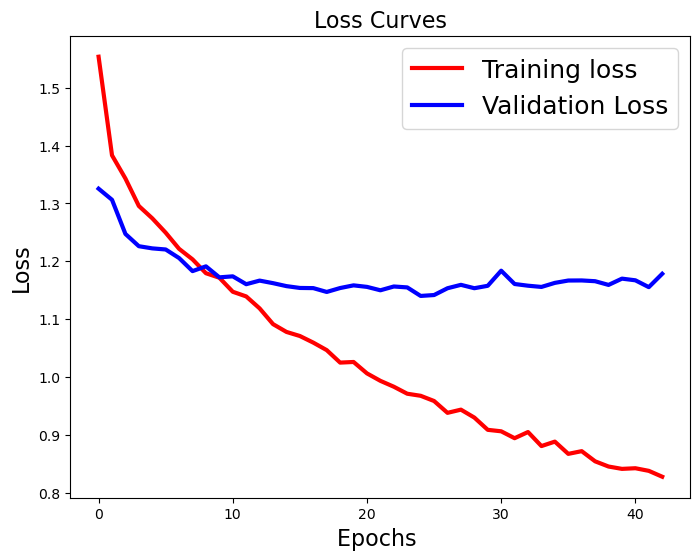

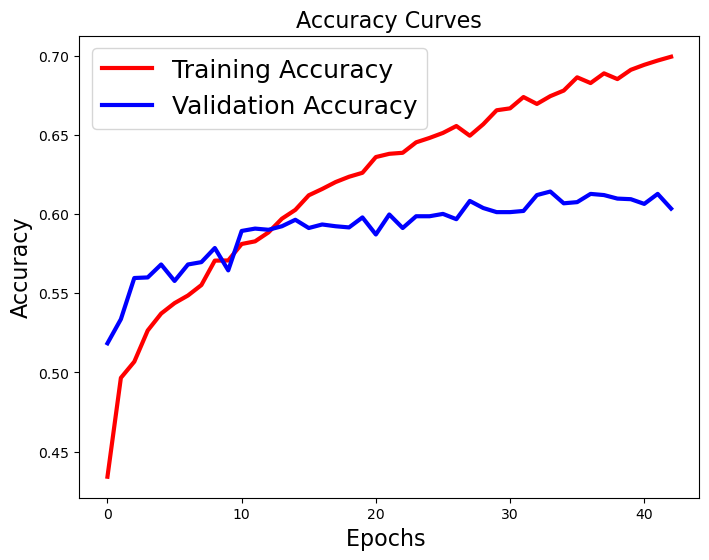

In [23]:
plot_history(history)

In [37]:
model = load_model("best_model_learning_mobilnet.keras")

In [38]:
y_pred = model.predict(X_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step


In [39]:
y_pred = np.argmax(y_pred, axis=1)

In [40]:
## y_test = np.argmax(y_test, axis=1)

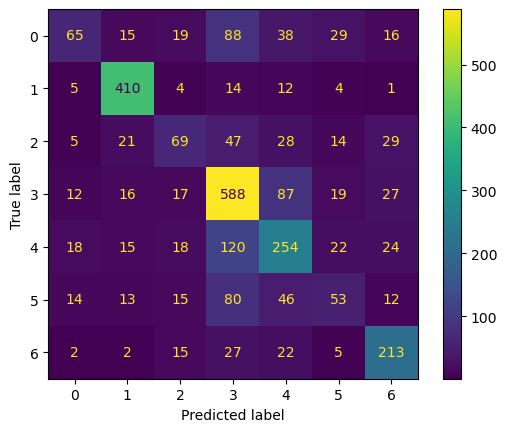

In [41]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [36]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# import os
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# import os
# import numpy as np
# import cv2  # OpenCV pro konverzi na stupně šedi


# # Cesta k adresáři se vstupními obrázky
# input_dir = r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE\train_OK\disgust"  # Změň podle své struktury
# output_dir = r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE\disgust_1"  # Kam se uloží augmentované obrázky

# # Vytvoření adresáře pro augmentované obrázky, pokud neexistuje
# os.makedirs(output_dir, exist_ok=True)

# # Nastavení augmentace
# datagen = ImageDataGenerator(
#     rotation_range=30,        # Náhodná rotace do 30 stupňů
#     width_shift_range=0.2,    # Horizontální posun do 20 % šířky
#     height_shift_range=0.2,   # Vertikální posun do 20 % výšky
#     zoom_range=0.2,           # Náhodný zoom (přiblížení/oddálení)
#     horizontal_flip=True,     # Náhodné otočení
#    ## brightness_range=[0.8, 1.2],  # Jas mezi 80 % a 120 %
#     fill_mode='nearest'       # Vyplnění nových pixelů
# )

# # Procházení obrázků ve složce
# for filename in os.listdir(input_dir):
#     if filename.endswith(".jpg"):  
#         img_path = os.path.join(input_dir, filename)
        
#         # Načtení obrázku a změna velikosti
#         img = load_img(img_path, target_size=(48, 48))
#         x = img_to_array(img)  # Převod na numpy pole
        
#         x = x.astype(np.uint8)
        
#         # Převod na stupně šedi pomocí OpenCV
#         x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)

#         # Reshape na 48x48x1 (1 kanál)
#         x = np.expand_dims(x, axis=-1)

#         # Přidání batch dimenze
#         x = np.expand_dims(x, axis=0)

#         # Generování a ukládání augmentovaných obrázků
#         i = 0
#         for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix="aug", save_format="jpg"):
#             i += 1
#             if i > 10:
#                 break


In [37]:
## img_1 = Image.open(r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE\train_OK\disgust\Training_88580213.jpg")

In [38]:
## img_1 = np.array(img_1)

In [39]:
## plt.imshow(img_1)

In [43]:
## img_1.shape

In [97]:
## model_testovani = load_model("best_model_learning_mobilnet.keras")

In [132]:
model_testovani = load_model("best_model_learning.keras")

In [133]:
obrazek_mobilnet = cv2.imread('muz_bryle.jpg') # načítam obrazek
## obrazek = obrazek.resize(512, 420)
## obrazek = cv2.imread('bryle.jpg') # načítam obrazek
obrazek_mobilnet = cv2.cvtColor(obrazek_mobilnet, cv2.COLOR_BGR2RGB)  # konverze barev z BlueGreenRed na RedGreenB
## obrazek

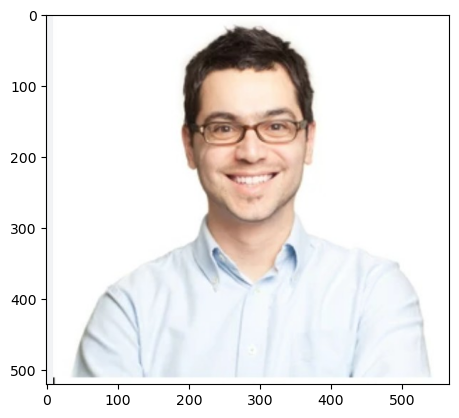

In [134]:
plt.imshow(obrazek_mobilnet)

In [135]:
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet import preprocess_input

# Načtení obrázku
## obrazek_mobilnet = cv2.imread("obrazek_mobilnet.jpg")  # Cesta k obrázku
obrazek_mobilnet = cv2.resize(obrazek_mobilnet, (48, 48))  # MobileNet používá 224x224

# Převod na float32 a normalizace
obrazek_mobilnet = np.array(obrazek_mobilnet, dtype=np.float32)  # Převod na float32
obrazek_mobilnet = preprocess_input(obrazek_mobilnet)  # Normalizace na rozsah vhodný pro MobileNet

# Přidání dimenze (batch_size = 1)
obrazek_mobilnet = np.expand_dims(obrazek_mobilnet, axis=0)  # Z (224, 224, 3) na (1, 224, 224, 3)

# Ověření tvaru
print("Nový tvar:", obrazek_mobilnet.shape)

Nový tvar: (1, 48, 48, 3)


In [136]:
prediction_mobilnet = model_testovani.predict(obrazek_mobilnet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [137]:
prediction_mobilnet

array([[0.01810451, 0.5456886 , 0.00732696, 0.02715735, 0.12377997,
        0.27278638, 0.0051562 ]], dtype=float32)

In [138]:
predicted_emotion_mobilnet = np.argmax(prediction_mobilnet) ## , axis=1)

In [139]:
predicted_emotion_mobilnet

1

In [140]:
encoding[predicted_emotion_mobilnet]

'disgust'